In [81]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import pickle

In [82]:
train_data = pd.read_excel('Flight Dataset/Data_Train.xlsx')
train_data.dropna(inplace=True)
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [83]:
def newd(x):
    if x=='New Delhi':
        return 'Delhi'
    else:
        return x

train_data['Destination'] = train_data['Destination'].apply(newd)
train_data['Source'] = train_data['Source'].apply(newd)

In [84]:
# Define a function to convert duration to minutes
def convert_duration(duration):
    if isinstance(duration, str):
        # Split the duration string into hour and minute components
        hours, minutes = 0, 0
        for component in duration.split():
            if 'h' in component:
                hours = int(component[:-1])
            elif 'm' in component:
                minutes = int(component[:-1])
        # Convert duration to minutes and return
        total_minutes = hours * 60 + minutes
        return total_minutes
    else:
        return duration

# Apply the function to the 'Duration' column
train_data['Duration'] = train_data['Duration'].apply(convert_duration)


In [85]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,Delhi,BLR → DEL,22:20,01:10 22 Mar,170,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,445,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,1140,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,325,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,Delhi,BLR → NAG → DEL,16:50,21:35,285,1 stop,No info,13302


Checking min duration of each route

In [53]:
# Filter the dataset to include only the entries where the source is Bangalore and the destination is Cochin
filtered_df = train_data[(train_data['Source'] == 'Kolkata') & (train_data['Destination'] == 'Banglore') & (train_data['Total_Stops'] == '1 stop')]

# Get the number of entries where the source is Bangalore and the destination is Cochin
num_entries = len(filtered_df)

# Print the number of entries
print('Number of entries where source is Bangalore and destination is Cochin:', num_entries)

Number of entries where source is Bangalore and destination is Cochin: 1834


In [49]:
# Group the dataset by source and destination cities, and find the minimum duration for each group
duration_df = train_data.groupby(['Source', 'Destination'])['Duration'].min()

# Loop through all the unique combinations of source and destination cities
for source in train_data['Source'].unique():
    for destination in train_data['Destination'].unique():
        # Check if the current combination of source and destination cities has a non-null minimum duration
        if (source, destination) in duration_df.index:
            # Get the minimum duration for the current combination of source and destination cities
            min_duration = duration_df[(source, destination)]
            print('Source:', source, 'Destination:', destination, 'Minimum Duration:', min_duration)

Source: Banglore Destination: Delhi Minimum Duration: 10h 10m
Source: Kolkata Destination: Banglore Minimum Duration: 10h 10m
Source: Delhi Destination: Cochin Minimum Duration: 10h
Source: Chennai Destination: Kolkata Minimum Duration: 2h 15m
Source: Mumbai Destination: Hyderabad Minimum Duration: 10h 5m


In [94]:
# Filter the dataset to include only non-stop flights
df = train_data[train_data['Total_Stops'] == 'non-stop']

# df

# Group the dataset by source and destination cities and find the minimum duration
duration_df = df.groupby(['Source', 'Destination'])['Duration'].min()

# Get the unique values from the 'Source' column
unique_sources = df['Source'].unique()

# Get the unique values from the 'Destination' column
unique_destinations = df['Destination'].unique()

# Print the unique values from the 'Source' and 'Destination' columns
print('Unique sources:', unique_sources)
print('Unique destinations:', unique_destinations)

for x in unique_sources:
    for y in unique_destinations:
        # Filter the dataset to include only the entries where the source is Bangalore and the destination is Cochin
        filtered_df = df[(df['Source'] == x) & (df['Destination'] == y)]

        num_entries = len(filtered_df)
        if x != y and num_entries!= 0:
            print(x+ " "+y+ " "+str(duration_df[(x, y)]))

Unique sources: ['Banglore' 'Kolkata' 'Chennai' 'Delhi' 'Mumbai']
Unique destinations: ['Delhi' 'Banglore' 'Kolkata' 'Cochin' 'Hyderabad']
Banglore Delhi 155
Kolkata Banglore 140
Chennai Kolkata 135
Delhi Cochin 170
Mumbai Hyderabad 75


In [95]:
# Filter the dataset to include only non-stop flights
df = train_data[train_data['Total_Stops'] == '1 stop']

# df

# Group the dataset by source and destination cities and find the minimum duration
duration_df = df.groupby(['Source', 'Destination'])['Duration'].min()

# Get the unique values from the 'Source' column
unique_sources = df['Source'].unique()

# Get the unique values from the 'Destination' column
unique_destinations = df['Destination'].unique()

# Print the unique values from the 'Source' and 'Destination' columns
print('Unique sources:', unique_sources)
print('Unique destinations:', unique_destinations)

for x in unique_sources:
    for y in unique_destinations:
        # Filter the dataset to include only the entries where the source is Bangalore and the destination is Cochin
        filtered_df = df[(df['Source'] == x) & (df['Destination'] == y)]

        num_entries = len(filtered_df)
        if x != y and num_entries!= 0:
            print(x+ " "+y+ " "+str(duration_df[(x, y)]))

Unique sources: ['Kolkata' 'Banglore' 'Delhi' 'Mumbai']
Unique destinations: ['Banglore' 'Delhi' 'Cochin' 'Hyderabad']
Kolkata Banglore 215
Banglore Delhi 240
Delhi Cochin 265
Mumbai Hyderabad 195


In [114]:
# Filter the dataset to include only non-stop flights
df = train_data[train_data['Total_Stops'] == '2 stops']

# df

# Group the dataset by source and destination cities and find the minimum duration
duration_df = df.groupby(['Source', 'Destination'])['Duration'].min()

# Get the unique values from the 'Source' column
unique_sources = df['Source'].unique()

# Get the unique values from the 'Destination' column
unique_destinations = df['Destination'].unique()

# Print the unique values from the 'Source' and 'Destination' columns
print('Unique sources:', unique_sources)
print('Unique destinations:', unique_destinations)

for x in unique_sources:
    for y in unique_destinations:
        # Filter the dataset to include only the entries where the source is Bangalore and the destination is Cochin
        filtered_df = df[(df['Source'] == x) & (df['Destination'] == y)]

        num_entries = len(filtered_df)
        if x != y and num_entries!= 0:
            print(x+ " "+y+ " "+str(duration_df[(x, y)]))

Unique sources: ['Kolkata' 'Delhi' 'Banglore' 'Mumbai']
Unique destinations: ['Banglore' 'Cochin' 'Delhi' 'Hyderabad']
Kolkata Banglore 335
Delhi Cochin 425
Banglore Delhi 420
Mumbai Hyderabad 150


In [100]:
# Filter the dataset to include only the entries where the source is Mumbai and the destination is Hyderabad
filtered_df = train_data[(train_data['Source'] == 'Mumbai') & (train_data['Destination'] == 'Hyderabad') & (train_data['Total_Stops'] == '2 stops')]

# Find the minimum duration of the flights
min_duration = filtered_df['Duration'].min()

print(f"The minimum duration of a flight from Mumbai to Hyderabad with 2 stops is {min_duration} minutes.")


The minimum duration of a flight from Mumbai to Hyderabad with 2 stops is 5 minutes.


In [112]:
# Find the row(s) where the duration is 5 minutes
rows_to_drop = train_data[train_data['Duration'] == 5].index
print(rows_to_drop)

# # Drop the row(s)
train_data.drop(rows_to_drop, inplace=True)

# # Verify that the row(s) have been dropped
# print(train_data[train_data['Duration'] == '5']) # This should print an empty DataFrame


Int64Index([6474], dtype='int64')


In [113]:
# Filter the dataset to include only the entries where the source is Mumbai and the destination is Hyderabad
filtered_df = train_data[(train_data['Source'] == 'Mumbai') & (train_data['Destination'] == 'Hyderabad') & (train_data['Total_Stops'] == '2 stops')]

# Find the minimum duration of the flights
min_duration = filtered_df['Duration'].min()

print(f"The minimum duration of a flight from Mumbai to Hyderabad with 2 stops is {min_duration} minutes.")


The minimum duration of a flight from Mumbai to Hyderabad with 2 stops is 150 minutes.


In [97]:
# Filter the dataset to include only non-stop flights
df = train_data[train_data['Total_Stops'] == '3 stops']

# df

# Group the dataset by source and destination cities and find the minimum duration
duration_df = df.groupby(['Source', 'Destination'])['Duration'].min()

# Get the unique values from the 'Source' column
unique_sources = df['Source'].unique()

# Get the unique values from the 'Destination' column
unique_destinations = df['Destination'].unique()

# Print the unique values from the 'Source' and 'Destination' columns
print('Unique sources:', unique_sources)
print('Unique destinations:', unique_destinations)

for x in unique_sources:
    for y in unique_destinations:
        # Filter the dataset to include only the entries where the source is Bangalore and the destination is Cochin
        filtered_df = df[(df['Source'] == x) & (df['Destination'] == y)]

        num_entries = len(filtered_df)
        if x != y and num_entries!= 0:
            print(x+ " "+y+ " "+str(duration_df[(x, y)]))

Unique sources: ['Delhi' 'Kolkata' 'Banglore' 'Mumbai']
Unique destinations: ['Cochin' 'Banglore' 'Delhi' 'Hyderabad']
Delhi Cochin 565
Kolkata Banglore 805
Banglore Delhi 685
Mumbai Hyderabad 1175


In [98]:
# Filter the dataset to include only non-stop flights
df = train_data[train_data['Total_Stops'] == '4 stops']

# df

# Group the dataset by source and destination cities and find the minimum duration
duration_df = df.groupby(['Source', 'Destination'])['Duration'].min()

# Get the unique values from the 'Source' column
unique_sources = df['Source'].unique()

# Get the unique values from the 'Destination' column
unique_destinations = df['Destination'].unique()

# Print the unique values from the 'Source' and 'Destination' columns
print('Unique sources:', unique_sources)
print('Unique destinations:', unique_destinations)

for x in unique_sources:
    for y in unique_destinations:
        # Filter the dataset to include only the entries where the source is Bangalore and the destination is Cochin
        filtered_df = df[(df['Source'] == x) & (df['Destination'] == y)]

        num_entries = len(filtered_df)
        if x != y and num_entries!= 0:
            print(x+ " "+y+ " "+str(duration_df[(x, y)]))

Unique sources: ['Banglore']
Unique destinations: ['Delhi']
Banglore Delhi 1770


In [60]:
# # Filter the dataset to include only the entries where the source is Kolkata and the destination is Bangalore with Total_Stops as "1 stop"
# filtered_df = train_data[(train_data['Source'] == 'Kolkata') & (train_data['Destination'] == 'Banglore') & (train_data['Total_Stops'] == '1 stop')]

# # Sort the filtered dataset by duration in ascending order
# sorted_df = filtered_df.sort_values(by=['Duration'], ascending=False)

# # Print the sorted dataset
# print(sorted_df['Duration'])

2219       9h 5m
4857       9h 5m
1873       9h 5m
10454      9h 5m
9923       9h 5m
          ...   
6924     10h 25m
2384     10h 25m
2363     10h 25m
5715     10h 25m
2517     10h 25m
Name: Duration, Length: 1834, dtype: object


In [88]:
# # Filter the dataset to include only the entries where the Total_Stops is "1 stop"
# df_filtered = train_data[train_data['Total_Stops'] == '1 stop']

# # Group the filtered dataset by source and destination cities and find the minimum duration
# duration_df = df_filtered.groupby(['Source', 'Destination'])['Duration'].max()
# # print(duration_df)

# # Print the minimum duration for Delhi to Cochin
# # print(duration_df[('Delhi', 'Cochin')])

# # Get the unique values from the 'Source' column
# unique_sources = train_data['Source'].unique()

# # Get the unique values from the 'Destination' column
# unique_destinations = train_data['Destination'].unique()

# # Print the unique values from the 'Source' and 'Destination' columns
# print('Unique sources:', unique_sources)
# print('Unique destinations:', unique_destinations)

# # Loop through all the unique combinations of source and destination cities and filter the dataset to include only the entries where the Total_Stops is "1 stop"
# for source in unique_sources:
#     for destination in unique_destinations:
#         filtered_df = df_filtered[(df_filtered['Source'] == source) & (df_filtered['Destination'] == destination)]
#         # print('Source:', source, 'Destination:', destination, 'Total_Stops: 1 stop', 'Number of entries:', len(filtered_df))

# # Get the number of entries where the source is Bangalore and the destination is Cochin
#         num_entries = len(filtered_df)
#         if source != destination and num_entries!= 0:
#             print(source+ " "+destination+ " "+str(duration_df[(source, destination)]))


Unique sources: ['Banglore' 'Kolkata' 'Delhi' 'Chennai' 'Mumbai']
Unique destinations: ['Delhi' 'Banglore' 'Cochin' 'Kolkata' 'Hyderabad']
Banglore Delhi 1730
Kolkata Banglore 1750
Delhi Cochin 1685
Mumbai Hyderabad 1610


In [39]:
# # Group the dataset by source, destination cities, and number of stops, and find the minimum duration
# duration_df = train_data.groupby(['Source', 'Destination', 'Total_Stops'])['Duration'].min()

# # Print the minimum duration for Delhi to Cochin with 1 stop
# print(duration_df[('Kolkata', 'Banglore', '1 stop')])

# # Get the unique values from the 'Source' column
# unique_sources = train_data['Source'].unique()

# # Get the unique values from the 'Destination' column
# unique_destinations = train_data['Destination'].unique()

# # Get the unique values from the 'Total_Stops' column
# unique_stops = train_data['Total_Stops'].unique()
# print(unique_stops)

# # Loop through all the unique combinations of source, destination cities, and number of stops
# for source in unique_sources:
#     for destination in unique_destinations:
#         for stops in unique_stops:
#             # Filter the dataset to include only the entries with the given source, destination, and number of stops
#             filtered_df = df[(df['Source'] == source) & (df['Destination'] == destination) & (df['Total_Stops'] == stops)]
#             # Find the minimum duration for the filtered dataset
#             min_duration = filtered_df['Duration'].min()
#             if not pd.isna(min_duration):
#                 print('Source:', source, 'Destination:', destination, 'Total_Stops:', stops, 'Minimum Duration:', min_duration)


10h 25m
['non-stop' '2 stops' '1 stop' '3 stops' '4 stops']
Source: Banglore Destination: Delhi Total_Stops: non-stop Minimum Duration: 2h 35m
Source: Kolkata Destination: Banglore Total_Stops: non-stop Minimum Duration: 2h 20m
Source: Delhi Destination: Cochin Total_Stops: non-stop Minimum Duration: 2h 50m
Source: Chennai Destination: Kolkata Total_Stops: non-stop Minimum Duration: 2h 15m
Source: Mumbai Destination: Hyderabad Total_Stops: non-stop Minimum Duration: 1h 15m


In [6]:
train_data['Destination'].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1001.4+ KB


In [65]:
train_data['Journey_day'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d/%m/%Y').dt.day
train_data['Journey_month'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d/%m/%Y').dt.month

train_data.drop('Date_of_Journey',inplace=True,axis=1)

train_data.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,Banglore,Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


In [66]:
train_data['Dep_hour'] = pd.to_datetime(train_data['Dep_Time']).dt.hour
train_data['Dep_min'] = pd.to_datetime(train_data['Dep_Time']).dt.minute
train_data.drop('Dep_Time',axis=1,inplace=True)

train_data['Arrival_hour'] = pd.to_datetime(train_data['Arrival_Time']).dt.hour
train_data['Arrival_min'] = pd.to_datetime(train_data['Arrival_Time']).dt.minute
train_data.drop('Arrival_Time',axis=1,inplace=True)
train_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [67]:
duration = list(train_data['Duration'])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:
        if 'h' in duration[i]:
            duration[i] = duration[i] + ' 0m'
        else:
            duration[i] = '0h ' + duration[i]

duration_hour = []
duration_min = []

for i in duration:
    h,m = i.split()
    duration_hour.append(int(h[:-1]))
    duration_min.append(int(m[:-1]))

    
train_data['Duration_hours'] = duration_hour
train_data['Duration_mins'] = duration_min
train_data.drop('Duration',axis=1,inplace=True)
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


In [73]:
train_data.dropna(subset=['Duration_hours', 'Duration_mins'], inplace=True)

In [74]:
# Concatenate the 'duration_hour' and 'duration_min' columns to get the total duration in minutes
train_data['Total_Duration'] = train_data['Duration_hours'].astype(int) * 60 + train_data['Duration_mins'].astype(int)


# # Find the minimum duration for each unique route based on the number of stops
# min_durations = df[df['Total_Stops'] == '1 stop'].groupby(['Source', 'Destination'])[['Dep_hour', 'Dep_min', 'Total_Duration']].min()

# # Concatenate 'Dep_hour' and 'Dep_min' columns to get the departure time in hours and minutes format
# min_durations['Departure_Time'] = min_durations['Dep_hour'].astype(str) + ':' + min_durations['Dep_min'].astype(str)

# # Rename the columns for better readability
# min_durations = min_durations.rename(columns={'Total_Duration': 'Minimum_Duration', 'Dep_hour': 'Departure_Hour', 'Dep_min': 'Departure_Minute'})

# # Print the minimum durations
# print(min_durations)

ValueError: invalid literal for int() with base 10: '50m'

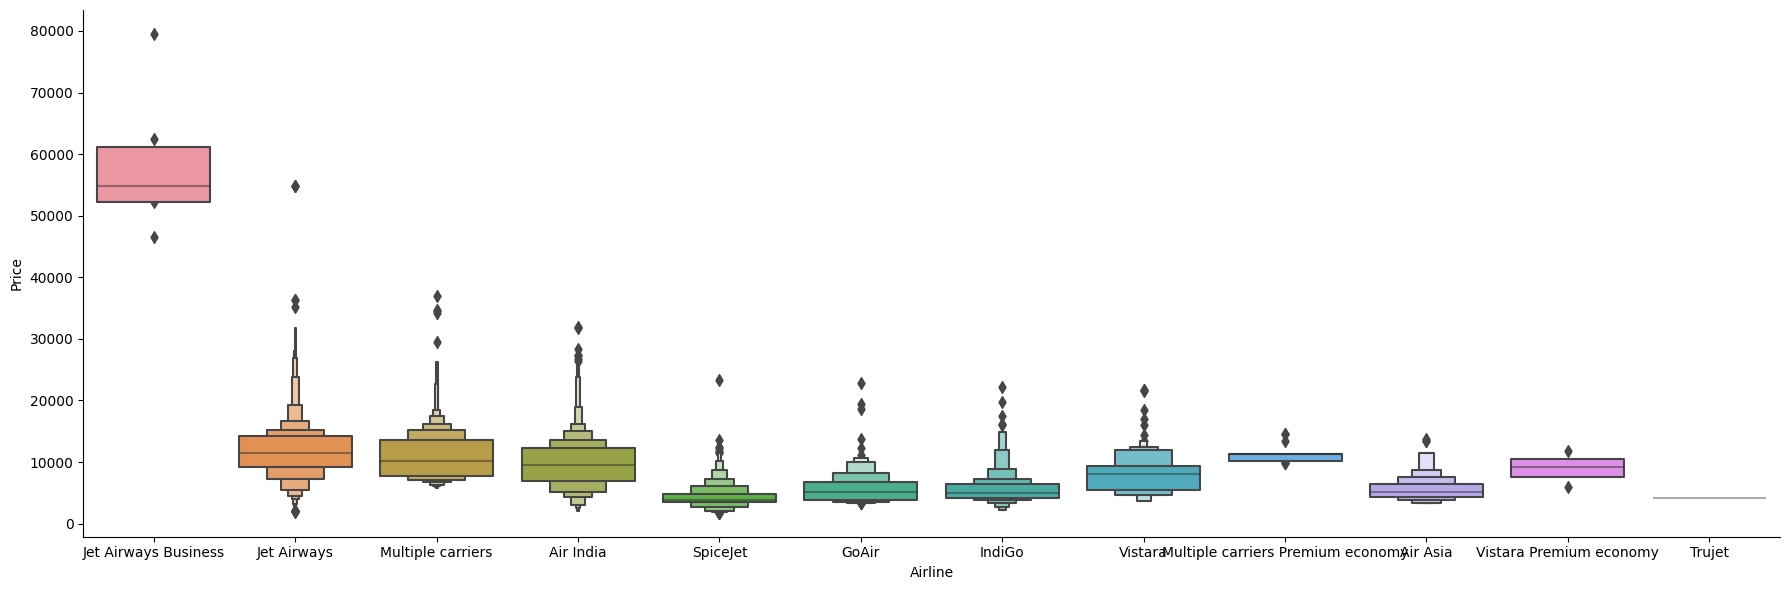

In [12]:
# we can observe that jet airways bussiness is he costliest airways
sns.catplot(x='Airline',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=6)

In [13]:
airline = train_data[['Airline']]
airline = pd.get_dummies(airline,drop_first=True)
airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


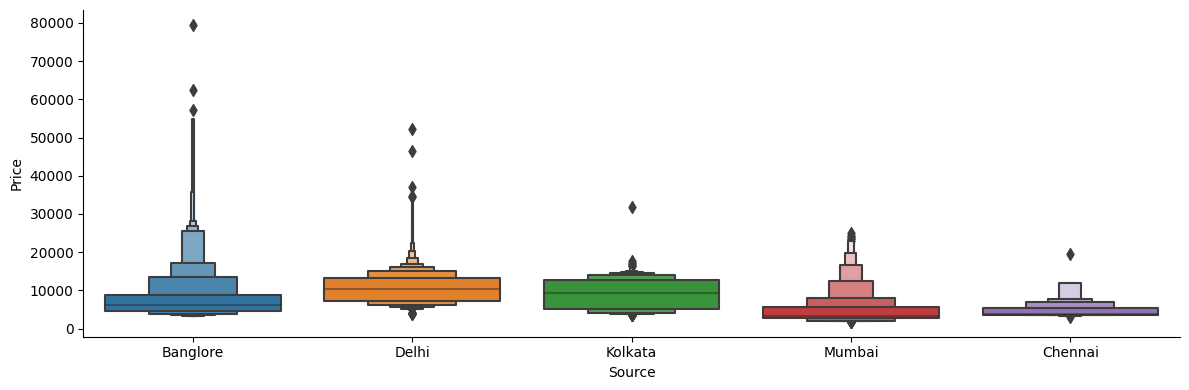

In [14]:
# If we are going from Banglore the prices are slightly higher as compared to other cities
sns.catplot(x='Source',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

In [15]:
source = train_data[['Source']]
source = pd.get_dummies(source,drop_first=True)
source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


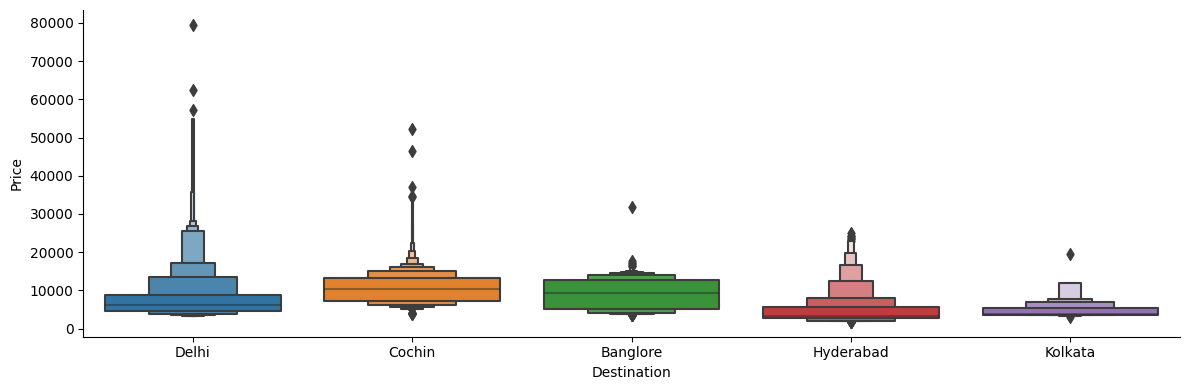

In [16]:
# If we are going to New Delhi the prices are slightly higher as compared to other cities
sns.catplot(x='Destination',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

In [17]:
destination = train_data[['Destination']]
destination = pd.get_dummies(destination,drop_first=True)
destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,1,0,0
1,0,0,0,0
2,1,0,0,0
3,0,0,0,0
4,0,1,0,0


In [18]:
train_data.drop(['Route','Additional_Info'],inplace=True,axis=1)

In [19]:
train_data['Total_Stops'].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [20]:
# acc to the data, price is directly prop to the no. of stops
train_data['Total_Stops'].replace({'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4},inplace=True)
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1,13302,1,3,16,50,21,35,4,45


In [21]:
print(airline.shape)
print(source.shape)
print(destination.shape)
print(train_data.shape)

(10682, 11)
(10682, 4)
(10682, 4)
(10682, 13)


In [22]:
data_train = pd.concat([train_data,airline,source,destination],axis=1)
data_train.drop(['Airline','Source','Destination'],axis=1,inplace=True)
data_train.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,3897,24,3,22,20,1,10,2,50,...,0,0,0,0,0,0,0,1,0,0
1,2,7662,1,5,5,50,13,15,7,25,...,0,0,0,0,1,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,...,0,0,0,1,0,0,1,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,...,0,0,0,0,1,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,...,0,0,0,0,0,0,0,1,0,0


# Feature Selection

Finding out the best feature which will contribute and have good relation with target variable. Following are some of the feature selection methods,

1. **heatmap** 
2. **feature_importance_** 
3. **SelectKBest**

In [23]:
data_train.columns

Index(['Total_Stops', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata'],
      dtype='object')

In [24]:
X = data_train.drop('Price',axis=1)
X.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,24,3,22,20,1,10,2,50,0,...,0,0,0,0,0,0,0,1,0,0
1,2,1,5,5,50,13,15,7,25,1,...,0,0,0,0,1,0,0,0,0,0
2,2,9,6,9,25,4,25,19,0,0,...,0,0,0,1,0,0,1,0,0,0
3,1,12,5,18,5,23,30,5,25,0,...,0,0,0,0,1,0,0,0,0,0
4,1,1,3,16,50,21,35,4,45,0,...,0,0,0,0,0,0,0,1,0,0


In [25]:
y = data_train['Price']
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

C:\Users\parhi\AppData\Local\Temp\ipykernel_30208\1098957341.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(),cmap='viridis',annot=True)


<Axes: >

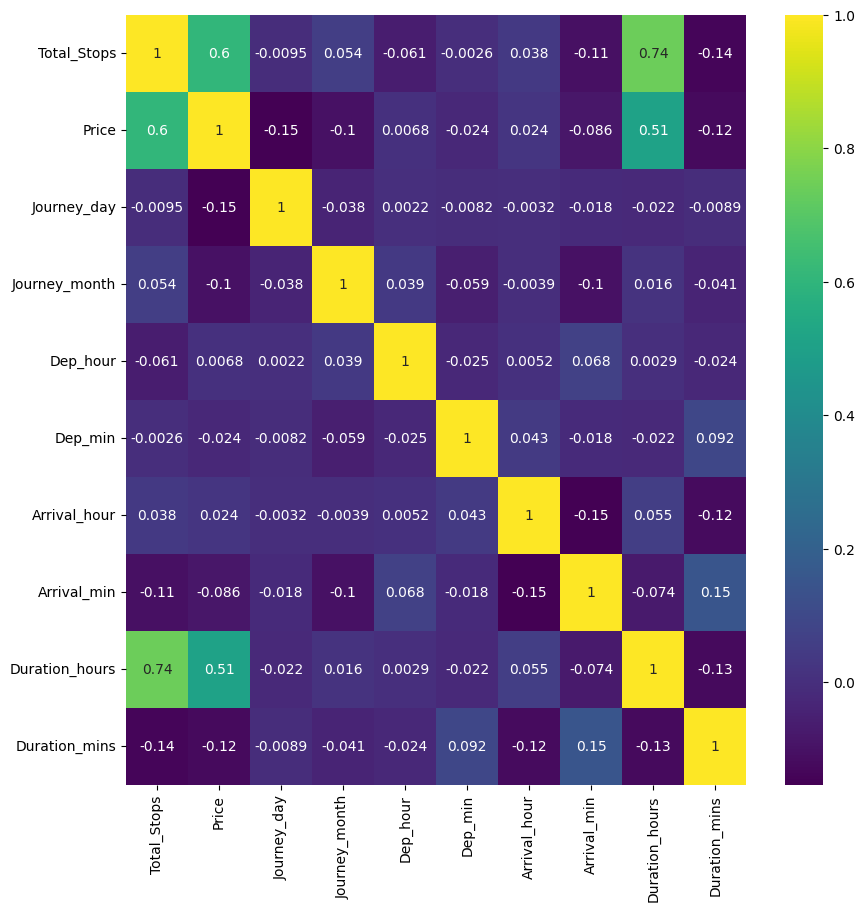

In [26]:
plt.figure(figsize=(10,10))
sns.heatmap(train_data.corr(),cmap='viridis',annot=True)

In [27]:
reg = ExtraTreesRegressor()
reg.fit(X,y)

print(reg.feature_importances_)

[2.39152508e-01 1.42494612e-01 5.78439655e-02 2.41682036e-02
 2.12203930e-02 2.84980503e-02 1.89309026e-02 1.21304866e-01
 1.77053961e-02 9.61801045e-03 1.72756697e-03 1.73906702e-02
 1.38353145e-01 6.74316121e-02 2.05482845e-02 8.41680229e-04
 4.98637028e-03 8.11512434e-05 4.81598955e-03 6.80959491e-05
 6.36924819e-04 1.00076194e-02 4.60479888e-03 8.59000643e-03
 1.06408059e-02 1.85803649e-02 8.90670639e-03 8.51299230e-04]


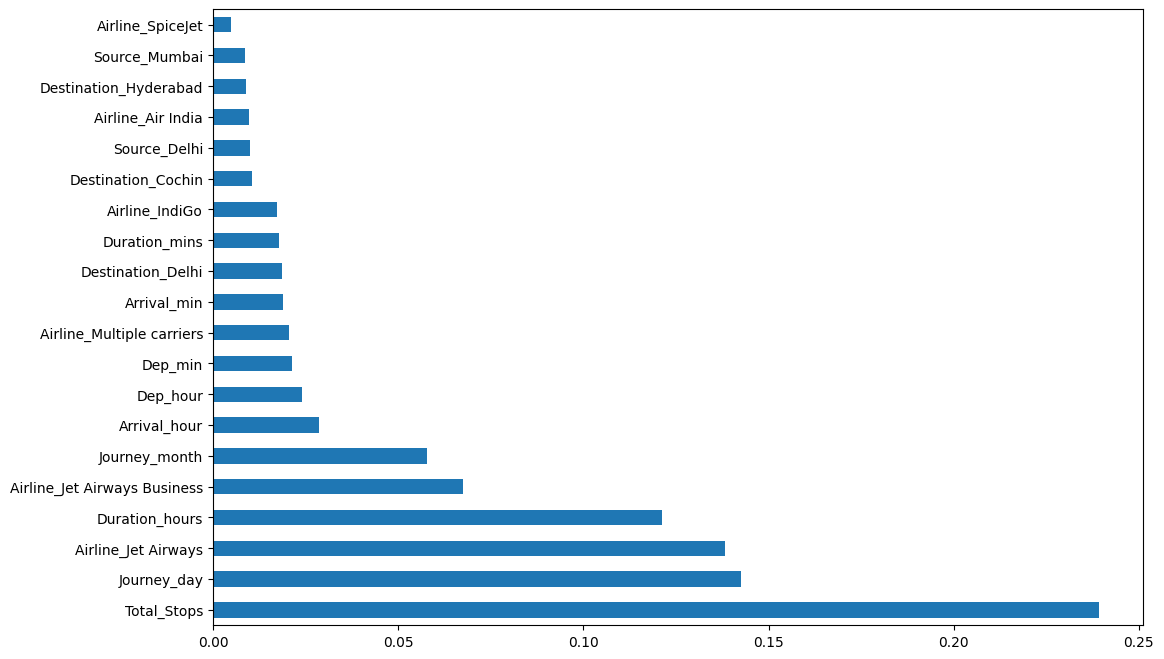

In [28]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

# Fitting model using Random Forest
1. Split dataset into train and test set in order to prediction w.r.t X_test
2. If needed do scaling of data(Scaling is not done in Random forest)
3. Import model
4. Fit the data
5. Predict w.r.t X_test
6. In regression check RSME Score
7. Plot graph

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Linear Regression:

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


lr = LinearRegression()

# Fit the model to the training data
lr.fit(X_train, y_train)

#make predictions
y_pred = lr.predict(X_test)

# Evaluate the model on the testing data
score = lr.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Accuracy of model :", score)
print("Mean squared error:", mse)
print("R-squared:", r2)

Accuracy of model : 0.6094366894926816
Mean squared error: 7839969.180595527
R-squared: 0.6094366894926816


# Decision Tree:

In [31]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=5, min_samples_split=10)

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

dt_score = dt.score(X_test, y_test)
dt_mse = mean_squared_error(y_test, y_pred)
dt_r2 = r2_score(y_test, y_pred)

print("Accuracy of model :", dt_score)
print("Mean squared error:", dt_mse)
print("R-squared:", dt_r2)

Accuracy of model : 0.6431503011341454
Mean squared error: 7163219.293637853
R-squared: 0.6431503011341454


# Random Forest:

In [32]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid,
                               scoring='neg_mean_squared_error', n_iter = 10, cv = 5, 
                               verbose=1, random_state=42, n_jobs = 1)
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\parhi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\parhi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\parhi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `ma

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [33]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [34]:
prediction = rf_random.predict(X_test)

<Figure size 800x800 with 0 Axes>

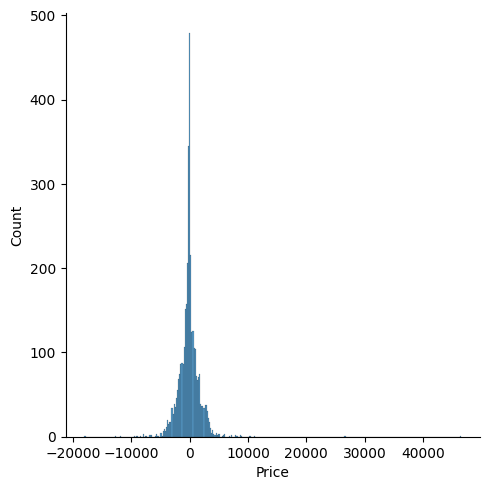

In [35]:
plt.figure(figsize = (8,8))
sns.displot(y_test-prediction)
plt.show()

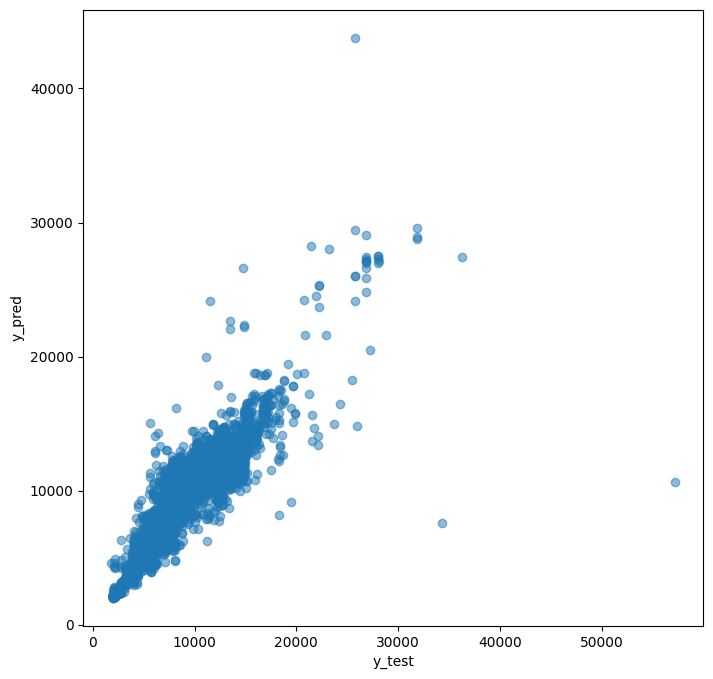

In [36]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [37]:
print('r2 score: ', metrics.r2_score(y_test,prediction))

r2 score:  0.811134519928871


In [38]:
rf_mse = mean_squared_error(y_test, y_pred)
print("Mean squared error:", rf_mse)

Mean squared error: 7163219.293637853


# Save the model to reuse it again

In [39]:
file = open('flight_rf.pkl', 'wb')
pickle.dump(rf_random, file)